<a href="https://colab.research.google.com/github/shadab4150/NLP-Disaster-tweet-prediction-Socialmedia/blob/master/real_or_not_disaster_tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.text import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
path = Path('/content/')
path.ls()

[PosixPath('/content/.config'),
 PosixPath('/content/sample_submission.csv'),
 PosixPath('/content/test.csv'),
 PosixPath('/content/train.csv'),
 PosixPath('/content/sample_data')]

In [0]:
df=pd.read_csv('train.csv')
df_test=pd.read_csv('test.csv')
sample=pd.read_csv('sample_submission.csv')

In [72]:
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [0]:
df_new=pd.read_csv('/content/socialmedia.csv')
df_new

In [73]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [19]:
df['text'][13]

'#Flood in Bago Myanmar #We arrived Bago'

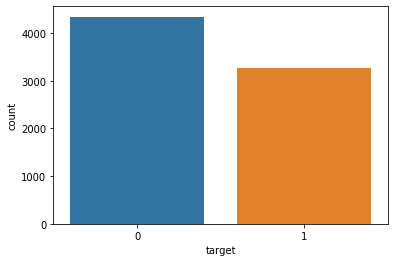

In [18]:
sns.countplot(x='target',data=df)

In [0]:
df.location.fillna(value='unknown',inplace=True)

In [0]:
df_test.location.fillna(value='unknown',inplace=True)

In [0]:
df['text_all']=df['location']+' '+df['text']

In [0]:
df_test['text_all']=df_test['location']+' '+df_test['text']

In [29]:
df_train=df[['text_all','target']].copy()
df_train.head()

,text_all,target
0,unknown Our Deeds are the Reason of this #eart...,1
1,unknown Forest fire near La Ronge Sask. Canada,1
2,unknown All residents asked to 'shelter in pla...,1
3,"unknown 13,000 people receive #wildfires evacu...",1
4,unknown Just got sent this photo from Ruby #Al...,1


In [47]:
df_train.columns=['text','label']
df_train.head()

,text,label
0,unknown Our Deeds are the Reason of this #eart...,1
1,unknown Forest fire near La Ronge Sask. Canada,1
2,unknown All residents asked to 'shelter in pla...,1
3,"unknown 13,000 people receive #wildfires evacu...",1
4,unknown Just got sent this photo from Ruby #Al...,1


In [35]:
df_test1=df[['text_all']].copy()
df_test1.head()

,text_all
0,unknown Our Deeds are the Reason of this #eart...
1,unknown Forest fire near La Ronge Sask. Canada
2,unknown All residents asked to 'shelter in pla...
3,"unknown 13,000 people receive #wildfires evacu..."
4,unknown Just got sent this photo from Ruby #Al...


In [0]:
df_train.to_csv('texts.csv',index=False)

In [0]:
df_test1.to_csv('texts_test.csv',index=False)

In [36]:
idcode=df_test.id.values
idcode

array([    0,     2,     3,     9, ..., 10865, 10868, 10874, 10875])

In [0]:
text_columns=['text']
label_columns=['target']
BATCH_SIZE=128

In [55]:
tweets = pd.concat([df[text_columns], df_test[text_columns]])
print(tweets.shape)

(10876, 1)


In [74]:
tweets.head()

,text
0,Our Deeds are the Reason of this #earthquake M...
1,Forest fire near La Ronge Sask. Canada
2,All residents asked to 'shelter in place' are ...
3,"13,000 people receive #wildfires evacuation or..."
4,Just got sent this photo from Ruby #Alaska as ...


In [56]:
data_lm = (TextList.from_df(tweets)
           #Inputs: all the text files in path
            .split_by_rand_pct(0.15)
           #We randomly split and keep 10% for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=BATCH_SIZE))
data_lm.save('tmp_lm')

In [57]:
data_lm.show_batch()

idx,text
0,"rockyfire xxmaj update = > xxmaj california xxmaj hwy . 20 closed in both xxunk due to xxmaj lake xxmaj county fire - # xxunk # wildfires xxbos # flood # disaster xxmaj heavy rain causes flash flooding of streets in xxmaj xxunk , xxmaj colorado xxmaj springs areas xxbos i 'm on top of the hill and i can see a fire in the xxunk ... xxbos xxmaj there"
1,forward to comment on the accident issue and xxunk xxunk # xxunk xxbos xxunk xxunk ps live and the game ... xxunk xxbos ' xxmaj the man who can drive himself further once the effort gets xxunk is the man who will win . ' \n xxmaj xxunk xxmaj xxunk xxbos 320 [ xxup ir ] xxup icemoon [ xxup aftershock ] | http : / / t.co /
2,an incident . xxmaj services at a halt just outside xxmaj xxunk . xxmaj ambulance on scene . xxbos xxmaj twelve feared killed in xxmaj pakistani air ambulance helicopter crash http : / / t.co / xxunk xxbos xxup ambulance xxup sprinter xxup automatic xxup frontline xxup vehicle xxup choice xxup of 14 xxup lez xxup compliant | ebay http : / / t.co / xxunk xxbos xxmaj new xxmaj
3,rt & & sign xxunk a stand & & be a voice for them ! # gilbert23 https : / / t.co / e8dl1lncvu xxbos xxmaj hey # xxup xxunk : xxmaj sign this petition to save the # xxunk @ # xxunk ! a xxunk sing - a - long is in order : http : / / t.co / xxunk xxbos xxunk and he 's the current xxmaj
4,! xxbos xxmaj armageddon averted by xxmaj el xxmaj xxunk \n # ultimalucha xxbos xxunk xxmaj if you have the time ( 23 hours ? ? ) the latest series about xxup ww1 xxmaj xxunk for xxmaj armageddon is extremely impressive . xxbos xxmaj xxunk xxmaj xxunk till xxmaj christmas xxup armageddon xxbos # xxmaj christians xxmaj united for # xxmaj israel ( # xxup xxunk ) : xxmaj


In [58]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5)

In [59]:
print('Model Summary:')
print(learn.layer_groups)

Model Summary:
[Sequential(
  (0): WeightDropout(
    (module): LSTM(400, 1152, batch_first=True)
  )
  (1): RNNDropout()
), Sequential(
  (0): WeightDropout(
    (module): LSTM(1152, 1152, batch_first=True)
  )
  (1): RNNDropout()
), Sequential(
  (0): WeightDropout(
    (module): LSTM(1152, 400, batch_first=True)
  )
  (1): RNNDropout()
), Sequential(
  (0): Embedding(5240, 400, padding_idx=1)
  (1): EmbeddingDropout(
    (emb): Embedding(5240, 400, padding_idx=1)
  )
  (2): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=5240, bias=True)
    (output_dp): RNNDropout()
  )
)]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.75E-02
Min loss divided by 10: 9.12E-02


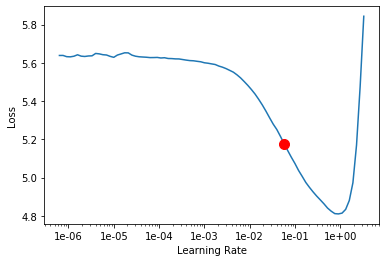

In [60]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [61]:
learn.fit_one_cycle(10, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,5.383852,4.799394,0.290469,00:16
1,4.712129,3.628133,0.389866,00:16
2,4.067582,3.231452,0.435558,00:16
3,3.601852,3.087623,0.453929,00:16
4,3.279905,3.026299,0.461205,00:16
5,3.043091,2.999218,0.467634,00:16
6,2.861644,2.981815,0.470536,00:16
7,2.744063,2.976127,0.471071,00:16
8,2.647296,2.970558,0.471741,00:16
9,2.583479,2.970441,0.471696,00:16


In [0]:
learn.save('lm_model_tweets')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 1.32E-03


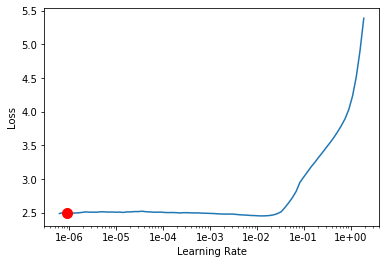

In [63]:
learn.load('lm_model_tweets')
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [64]:
learn.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.497954,2.944973,0.476540,00:21
1,2.432736,2.911660,0.479487,00:21
2,2.353122,2.890863,0.489487,00:21
3,2.281251,2.911966,0.490201,00:21
4,2.176233,2.909611,0.493482,00:21
5,2.077597,2.943260,0.490558,00:21
6,1.968259,2.950802,0.493415,00:21
7,1.871373,2.964763,0.494531,00:21
8,1.797716,2.982693,0.493549,00:21
9,1.754957,2.982066,0.493996,00:21


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.98E-06
Min loss divided by 10: 8.32E-05


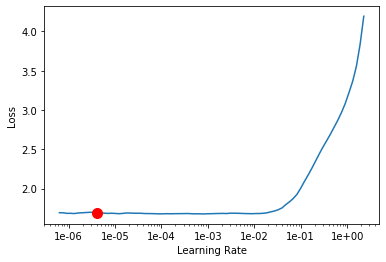

In [67]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [69]:
learn.fit_one_cycle(10, 1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,1.674042,2.982919,0.493839,00:21
1,1.690261,2.975440,0.494621,00:21
2,1.689576,2.984808,0.494129,00:21
3,1.673028,2.992206,0.492902,00:21
4,1.661455,2.996602,0.493996,00:21
5,1.651334,3.002342,0.493415,00:21
6,1.645618,3.006366,0.493884,00:21
7,1.630172,3.003667,0.494174,00:21
8,1.620169,3.005593,0.493571,00:21
9,1.615884,3.005670,0.494018,00:21


In [0]:
learn.save_encoder('ft_enc')

In [0]:
learn.save('lm_model_tweets1')

In [76]:
data_clas = (TextList.from_df(df, cols=text_columns, vocab=data_lm.vocab)
             .split_by_rand_pct(0.15)
             .label_from_df('target')
             .add_test(df_test[text_columns])
             .databunch(bs=BATCH_SIZE))

data_clas.save('tmp_clas')

In [0]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)

In [78]:
learn.load_encoder('ft_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (6472 items)
x: TextList
xxbos xxmaj our xxmaj xxunk are the xxmaj reason of this # earthquake xxmaj may xxup allah xxmaj forgive us all,xxbos xxmaj forest fire near xxmaj la xxmaj xxunk xxmaj xxunk . xxmaj canada,xxbos xxmaj all residents asked to ' shelter in place ' are being xxunk by officers . xxmaj no other evacuation or shelter in place orders are expected,xxbos xxunk people xxunk # wildfires evacuation orders in xxmaj california,xxbos xxmaj just got sent this photo from xxmaj xxunk # xxmaj alaska as smoke from # wildfires xxunk into a school
y: CategoryList
1,1,1,1,1
Path: .;

Valid: LabelList (1141 items)
x: TextList
xxbos xxunk i just screamed to the world how much i love xxmaj my xxmaj little xxmaj xxunk ? ?,xxbos xxmaj the whole food stamp gov . assistance program needs to be xxunk for wounded veterans xxunk and xxunk only . # xxunk,xxbos xxup @potus you until you drown by water xxunk the lungs . xxmaj you being alive has

In [79]:
learn.freeze_to(-1)
learn.summary()

SequentialRNN
Layer (type)         Output Shape         Param #    Trainable 
RNNDropout           [65, 400]            0          False     
______________________________________________________________________
RNNDropout           [65, 1152]           0          False     
______________________________________________________________________
RNNDropout           [65, 1152]           0          False     
______________________________________________________________________
BatchNorm1d          [1200]               2,400      True      
______________________________________________________________________
Dropout              [1200]               0          False     
______________________________________________________________________
Linear               [50]                 60,050     True      
______________________________________________________________________
ReLU                 [50]                 0          False     
________________________________________________

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.51E-03
Min loss divided by 10: 5.25E-02


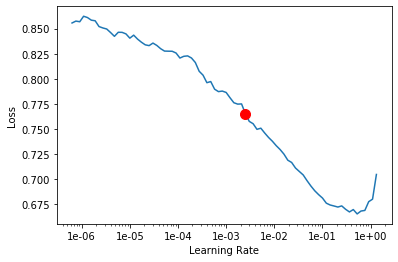

In [80]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [81]:
learn.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.679793,0.515614,0.740578,00:05
1,0.590263,0.477927,0.773883,00:06
2,0.542378,0.483762,0.775635,00:05
3,0.521325,0.469572,0.787029,00:05
4,0.500495,0.463912,0.794917,00:05
5,0.491429,0.461183,0.792287,00:06
6,0.484207,0.456206,0.789658,00:06
7,0.473789,0.453592,0.794917,00:06
8,0.472094,0.451471,0.801052,00:05
9,0.467932,0.451777,0.798422,00:06


In [0]:
learn.save('stage1')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 1.10E-07


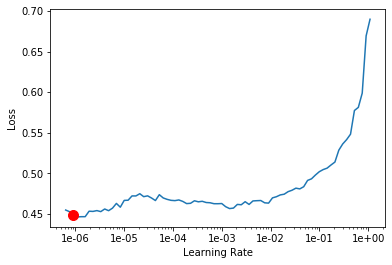

In [83]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [84]:
learn.load('stage1')
learn.freeze_to(-2)
learn.fit_one_cycle(5, slice(5e-3/2., 5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.492888,0.458236,0.787905,00:07
1,0.485259,0.478488,0.783523,00:07
2,0.466254,0.450427,0.812445,00:07
3,0.433755,0.471579,0.799299,00:07
4,0.408865,0.473732,0.794917,00:07


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.91E-06
Min loss divided by 10: 1.58E-03


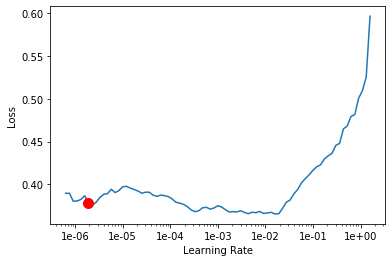

In [85]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [0]:
learn.save('stage2')

In [88]:
learn.unfreeze()
learn.fit_one_cycle(10, slice(1e-5,1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.384619,0.460100,0.804557,00:16
1,0.378987,0.466711,0.815075,00:16
2,0.372885,0.469352,0.811569,00:16
3,0.357708,0.485632,0.818580,00:17
4,0.345485,0.490489,0.809816,00:17
5,0.332450,0.503335,0.808940,00:15
6,0.315702,0.512608,0.818580,00:16
7,0.307208,0.515908,0.816827,00:16
8,0.287579,0.515958,0.813322,00:16
9,0.288992,0.525062,0.803681,00:15


# Final classifier accuracy is 80.3681%

In [0]:
learn.save('stage3')

In [0]:
learn.export()
learn.save('final')

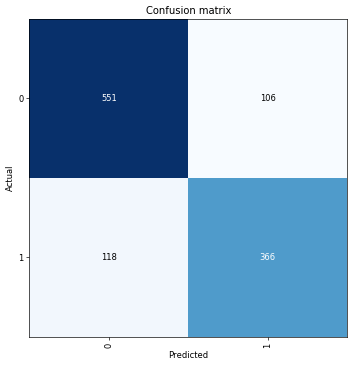

In [91]:
from fastai.vision import ClassificationInterpretation

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(6,6), dpi=60)

In [92]:
interp = TextClassificationInterpretation.from_learner(learn)
interp.show_top_losses(10)

Text,Prediction,Actual,Loss,Probability
xxbos xxmaj the xxmaj prophet ( peace be upon him ) said ' xxmaj save yourself from xxmaj hellfire even if it is by giving half a date in charity . ',0,1,8.00,0.00
xxbos xxmaj the xxmaj prophet ( peace be upon him ) said ' xxmaj save yourself from xxmaj hellfire even if it is by giving half a date in charity . ',0,1,8.00,0.00
xxbos xxunk xxmaj no reported flooding po in the area . xxmaj xxunk . # xxunk,1,0,7.61,0.00
xxbos xxunk so xxunk wanted to see that info on blight u got,0,1,6.46,0.00
xxbos xxmaj sassy city girl country hunk stranded in xxmaj smoky xxmaj mountain snowstorm # aoms http : / / t.co / xxunk # ibooklove # bookboost,1,0,5.57,0.00
xxbos xxunk xxup we xxup could xxup have xxup had xxup it xxrep 7 a xxrep 4 l iûªm not even on that season and iûªm devastated,0,1,5.53,0.00
xxbos xxmaj oops : xxmaj bounty hunters try to raid xxmaj phoenix police chief 's home http : / / t.co / xxunk,1,0,5.38,0.00
xxbos xxmaj reasons i should have gone to xxmaj xxunk today : tony played issues showed up sleeping w sirens played xxunk is there issues issues issues,0,1,5.32,0.00
xxbos xxunk _ xxunk xxunk if some of the 1st team players got xxunk xxmaj xxunk would get xxunk for playing xxunk ca n't win,0,1,5.31,0.00
xxbos # hot xxup c-130 specially modified to land in a stadium and rescue hostages in xxmaj iran in 1980 http : / / t.co / xxunk # prebreak # best,1,0,5.05,0.01


In [93]:
learn.predict(df_test.loc[4,'text'])

(Category 1, tensor(1), tensor([0.0016, 0.9984]))

In [0]:
def get_preds_as_nparray(ds_type) -> np.ndarray:
    """
    the get_preds method does not yield the elements in order by default
    we borrow the code from the RNNLearner to resort the elements into their correct order
    """
    preds = learn.get_preds(ds_type)[0].detach().cpu().numpy()
    sampler = [i for i in learn.data.dl(ds_type).sampler]
    reverse_sampler = np.argsort(sampler)
    return preds[reverse_sampler, :]

In [95]:
test_preds = get_preds_as_nparray(DatasetType.Test)

In [0]:
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission['target'] = np.argmax(test_preds, axis=1)
sample_submission.to_csv("predictions.csv", index=False, header=True)

# Mounting drive and saving the trained model

In [101]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pip install -U -q PyDrive

from google.colab import files
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import zipfile
import os
import sys

zipname = 'model_nlp'

def zipfolder(foldername, target_dir):            
    zipobj = zipfile.ZipFile(foldername + '.zip', 'w', zipfile.ZIP_DEFLATED)
    rootlen = len(target_dir) + 1
    for base, dirs, files in os.walk(target_dir):
        for file in files:
            fn = os.path.join(base, file)
            zipobj.write(fn, fn[rootlen:])

In [0]:
zipfolder(zipname, '/content/MODEL/')

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
file1 = drive.CreateFile()
file1.SetContentFile(zipname1+".zip")
file1.Upload()

## Lets use our trained language model to complete sentences or tweets

In [0]:
learn1 = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5)

In [119]:
learn1.load('lm_model_tweets1')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (9245 items)
x: LMTextList
xxbos xxmaj our xxmaj xxunk are the xxmaj reason of this # earthquake xxmaj may xxup allah xxmaj forgive us all,xxbos xxmaj forest fire near xxmaj la xxmaj xxunk xxmaj xxunk . xxmaj canada,xxbos xxunk people xxunk # wildfires evacuation orders in xxmaj california,xxbos xxmaj just got sent this photo from xxmaj xxunk # xxmaj alaska as smoke from # wildfires xxunk into a school,xxbos # rockyfire xxmaj update = > xxmaj california xxmaj hwy . 20 closed in both xxunk due to xxmaj lake xxmaj county fire - # xxunk # wildfires
y: LMLabelList
,,,,
Path: .;

Valid: LabelList (1631 items)
x: LMTextList
xxbos xxunk xxunk xxunk xxunk that car crash was pretty fun to film # xxunk,xxbos xxmaj remember to crowd around the xxunk xxunk like it 's armageddon and the bags are the last xxunk food xxunk on earth you animals .,xxbos xxup rip xxup rt xxunk : xxmaj on xxmaj aug. 6 1945 at xxunk xxup am xxmaj tokyo time the xxunk

## Lets check it
## To complete n_words words

In [135]:
TEXT = "Heavy rainfall is supposed to"
N_WORDS = 35
N_SENTENCES = 5
print("\n".join(learn1.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

Heavy rainfall is supposed to bring flooding flooding in Central California but a little - flash floods in Lafayette . It 's a disaster but it took half a month and did n't cut out .
Heavy rainfall is supposed to pass through southern Alberta and Alberta # Pakistan . # yyc # abstorm xxbos One Direction Is my pick for http : / / t.co / q2eblokeve Fan
Heavy rainfall is supposed to make the Ocean unstable . http : / / t.co / x xxbos ' If you think the word ' war ' comes to mind i would like to say that 's a
Heavy rainfall is supposed to create flash floods in Al Where and Al Plains . In the Al Plains of Al Plains and Al Plains , a flash flood
Heavy rainfall is supposed to create flash flooding and flash flooding . Heavy rain rains in Madhya Pradesh flash flood http : / / t.co / 4:30 xxbos More Natural Disaster Research


In [137]:
TEXT = "A cyclone is about to hit"
N_WORDS = 35
N_SENTENCES = 5
print("\n".join(learn1.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

A cyclone is about to hit the middle of the ocean and then make landfall Friday according to the World News ... xxbos Who Else Wants Documents Radiation Emergency Department
A cyclone is about to hit the central part of the world Without making landfall . You may have been with you ... xxbos The Hobbit : The Desolation of Smaug ( 2013 )
A cyclone is about to hit the wall . You hardly know when you will come . The Pandemonium http : / / t.co / thoyhrhkfj Fan Army # Beyhive http : / / t.co
A cyclone is about to hit the wall but it 's still not the closer it 's going to be the closer . So it 's too soon xxbos Please sign & & RT to save # okwx
A cyclone is about to hit the coast and you 're gon na drown yourself in the flood . xxbos The Latest : More Homes Razed by Northern California Wildfire - New


In [143]:
TEXT = "an earthquake hit the "
N_WORDS = 25
N_SENTENCES = 5
print("\n".join(learn1.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

an earthquake hit the  Volcano Hawaii http : / / t.co / 3 xxbos Obama Declares Disaster for Typhoon - Devastated
an earthquake hit the  Red Land of Iran in just 8 seconds . # Earthquake of 15 people ... http : / / t.co /
an earthquake hit the  West Coast http : / / t.co / Gaza Tsunami xxbos ' The Latest : More Homes
an earthquake hit the  North Island coast and area http : / / t.co / ÛÒ xxbos People are finally panicking about cable TV
an earthquake hit the  Rocky Fire in Rocky Fire http : / / t.co / BOOM # Armageddon xxbos The Prophet


# Pretty good tweet completion isn't it